In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement
type(Measurement)

sqlalchemy.orm.decl_api.DeclarativeMeta

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(most_recent.date)

2017-08-23


In [10]:
previous_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(previous_year)

2016-08-23


In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
previous_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
previous_year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= previous_year).\
    order_by(Measurement.date).all()

In [20]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
hawaii_prcp = pd.DataFrame(previous_year_prcp, columns=['date', 'prcp'])
hawaii_prcp

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


In [21]:
hawaii_prcp.count()

date    2230
prcp    2021
dtype: int64

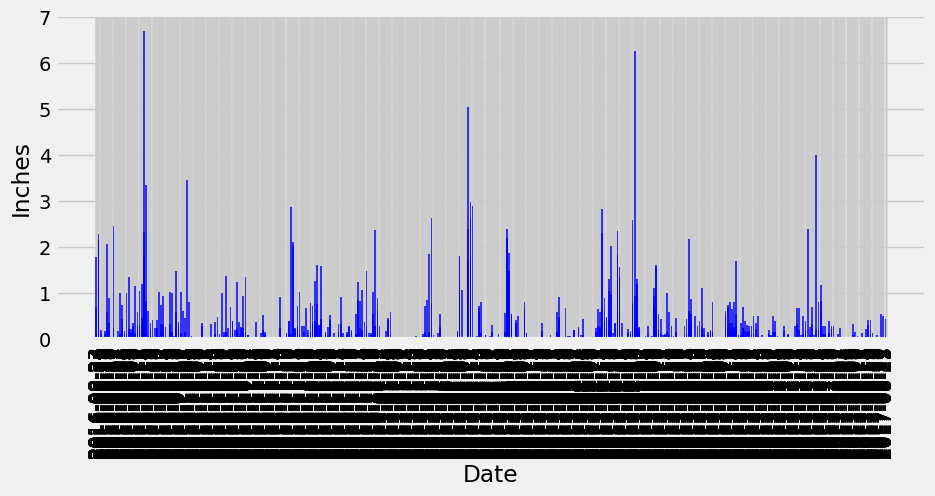

In [25]:

x_axis = np.arange(len(hawaii_prcp))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,4))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.bar(hawaii_prcp["date"], hawaii_prcp["prcp"], facecolor="blue", alpha=0.75, align="center")
plt.xticks(hawaii_prcp["date"], rotation="vertical")
plt.show()

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data

prcp_count = hawaii_prcp["prcp"].count()
prcp_mean = hawaii_prcp["prcp"].mean()
prcp_stdev = hawaii_prcp["prcp"].std()
prcp_min = hawaii_prcp["prcp"].min()
prcp_quartiles = hawaii_prcp["prcp"].quantile([.25,.5,.75])
lowerq_prcp = prcp_quartiles[0.25]
mid_prcp = prcp_quartiles[0.5]
upperq_prcp = prcp_quartiles[0.75]
prcp_max = hawaii_prcp["prcp"].max()

summary_stats = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
summary_values = [prcp_count, prcp_mean, prcp_stdev, prcp_min, lowerq_prcp, mid_prcp, upperq_prcp, prcp_max]
prcp_summary = pd.DataFrame(list(zip(summary_stats, summary_values)), columns=['stats', 'precipitation'])
prcp_summary.set_index('stats')


,precipitation
stats,
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
locations = session.query(Station).group_by(Station.station).count()
print(locations)

9


In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

#activity = session.query(Measurement.prcp).\
#    filter(Measurement.prcp >= '0').\
#    group_by(Measurement.station)

session.query(func.count(Measurement.station)).\
    group_by(Measurement.station)

#activity = sqlalchemy

#activity = sqlalchemy.select([Measurement.station, sqlalchemy.func.count(Measurement.station)
                              #]).group_by(Measurement.station).filter(Measurement.tobs > 1)
#result = engine.execute(activity).fetchall()
#for row in result:


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
most_active_station = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()

most_active_station


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
previous_year_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= previous_year).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()

most_active_station_tobs = pd.DataFrame(previous_year_tobs, columns=['date', 'tobs'])
most_active_station_tobs

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


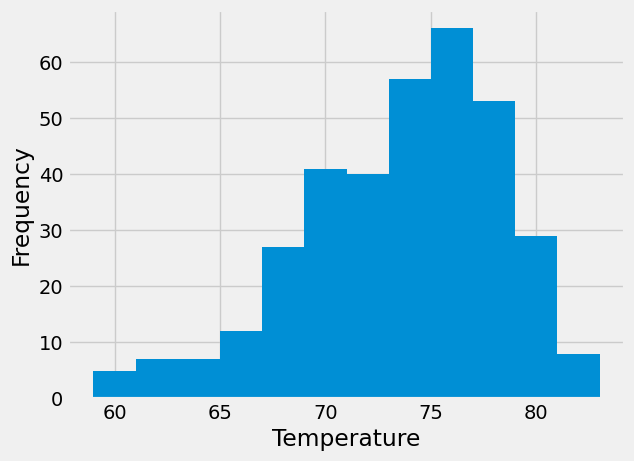

In [46]:
 # plot the results as a histogram

plt.hist(most_active_station_tobs['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
#plt.legend(loc="upper right")
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()